

# Scotiabank Quarterly Reports: Instant Analysis and Translation Powered by Custom Made Chatbot


This is a cutting-edge chatbot designed to analyze quarterly reports with ease. Where users can upload report files and receive instant, detailed answers to their queries. Leveraging advanced natural language processing, this chatbot provides real-time insights and translations of complex financial data. This tool simplifies financial analysis, making critical information more accessible and understandable.

Source: https://www.scotiabank.com/ca/en/about/investors-shareholders/financial-result.html

## Team Alpha

* Raemil Corniel
* Uma Maheshwari
* Sonal Parmar
* Jharana Adhikari
* Aparna Suresh1


Table of Content
0.  Install libraries needed to run the notebook
1.  Load Libraries
2.  Class and functions
3.  Load data
4.  Analysis data (before cleaning)
5.  Clean data
6.  Exploratory Data Analysis
7.  Modeling
> * I.  Load library and dataset
  * II. Define metrics functions
  * III. Bert (bert-base-uncased) and Metrics
  * IV. GPT and Metrics
  * V. Translations and Metrics
9. Conclusion






### 0. Install libraries needed to run the notebook

In [1]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requi

In [2]:
pip install tabula-py pypdf PdfReader pdfminer pdfminer.six jpype1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 44.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.5 MB/s eta 0:00:00
  Created wheel for pdfminer: filename=pdfminer-20191125-py3-none-any.whl size=6140081 sha256=a1a3e12d4509c68308b12451ee1ee3b3f32e58fcff3ba53894abef5289b90061
  Stored in directory: /root/.cache/pip/wheels/4e/c1/68/f7bd0a8f514661f76b5cbe3b5f76e0033d79f1296012cbbf72
Successfully built pdfminer


In [3]:
pip install rouge-score fuzzywuzzy langdetect langid transformers torch sentence_transformers


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 75.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-m

In [95]:
pip install rouge-score

### 1. Load Libraries

In [13]:
import pandas as pd
import re
import math

from pypdf import PdfReader
from pdfminer.converter import TextConverter
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser
from pdfminer.layout import LAParams
from pdfminer.high_level import extract_text

import io
import tabula
import jpype

from bs4 import BeautifulSoup

import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns


import nltk

from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter

In [14]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
#show all columns in a df
pd.set_option('display.max_columns', None)
#show full row info
pd.set_option('display.max_colwidth', None)

In [16]:
print("JPype version:", jpype.__version__)


JPype version: 1.5.0


### 2. Classes and Function
#### This is to avoid code repetition and for code clarity and reusability  

In [17]:
#load file, given a pdf file path
def load_file(pdf):
    #load the file
    document = PdfReader(pdf , 'rb')

    counter=0
    textList = []

    # only read first 11 pages the last 3 pages are not relevant (Forward-looking statements, Shareholders Information)
    while counter < (len(document.pages) -3):
        pageObj = document.pages[counter]

        textList.append(pageObj.extract_text())
        counter += 1

    #return a list with the pages of the document, this list does not contain tables only textual info
    return textList


In [18]:
#clean text from html tags, \n, extra spaces, urls, double spaces , lower case
def clean_text(fileText):

    #clean file text
    textCleannedList = []
    for textToProccess in fileText:
        #lower case
        textToProccess = textToProccess.lower()

        #remove all tags from html
        textToProccess= BeautifulSoup(textToProccess, 'html.parser').get_text()

        #remove newlines
        textToProccess= textToProccess.replace('\n',' ')

        #remove spaces
        textToProccess = textToProccess.strip()

        #remove urls
        patterns = re.compile(r'https?://\S+|www\.\S+')
        textToProccess = patterns.sub(' ', textToProccess)

        #remove double space
        textToProccess =re.sub("\s\s+" , " ", textToProccess)

        textCleannedList.append(textToProccess)

    return textCleannedList

# clean text for questioning
def clean_text_question(text):
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Normalize case
    text = text.lower()

    # Remove extra whitespace
    text = ' '.join(text.split())

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = text.split()
    cleaned_text = ' '.join([word for word in words if word.lower() not in stop_words])
    return cleaned_text

In [19]:
#get text from specific part of the document
#given a list of pages, start word, end word , and a tag for identifying type of information extracted
def extract_text_between_words_across_pages(text_pages, start_word, end_word, tag):
    extracted_texts = []
    #join all pages
    combined_text = "\n".join(text_pages)
    pattern = re.compile(re.escape(start_word) + '(.*?)' + re.escape(end_word), re.S)

    for match in pattern.finditer(combined_text):
        start_page, end_page = None, None
        start_index, end_index = match.start(), match.end()

        cumulative_length = 0
        for i, page in enumerate(text_pages):
            page_length = len(page)
            if start_page is None and start_index < cumulative_length + page_length:
                start_page = i + 1
            if end_page is None and end_index <= cumulative_length + page_length:
                end_page = i + 1
            cumulative_length += page_length + len("\n")
            if start_page is not None and end_page is not None:
                break

        extracted_texts.append({
            'start_page': start_page,
            'end_page': end_page,
            'start_word': start_word,
            'end_word': end_word,
            'tag':tag,
            'extracted_text': start_word +' '+ match.group(1).strip()
        })
    return extracted_texts

In [20]:
#given a list of pages, and  list of set of words (start, end) return a list of findings
def process_files_in_folder(text_pages, start_end_pairs, tag):
    all_extracted_texts = []

    for start_word, end_word in start_end_pairs:
        extracted_texts = extract_text_between_words_across_pages(text_pages, start_word, end_word,tag)
        all_extracted_texts.extend(extracted_texts)

    return all_extracted_texts


In [21]:

# Function to add dollar sign to numeric values
def add_dollar_sign(value):
    if isinstance(value, str) and value.replace(',', '').isdigit():
        return f'${value}'

    if isinstance(value, str) and '-' in value:
        return f'${value}'

    return value


# Define the function to convert values
def add_dollar_negative_sign(value):
    if isinstance(value, str):
        # Check if the value is in parentheses
        match = re.match(r'\(([\d,]+)\)', value)
        if match:
            # Extract the number, convert to negative, and format with dollar sign
            number = match.group(1).replace(',', '')
            return f'${-int(number):,}'
    return value




# Function to create new column names
def add_headers(df,numColJoin):
    new_columns = []
    for col in df.columns:
       # Join the first 3 rows for this column
       if 'Unnamed' in col:
          joined_name = ' '.join(df[col].iloc[:numColJoin].dropna().astype(str))
       else:
          joined_name =  col + ' ' + ' '.join(df[col].iloc[:numColJoin].dropna().astype(str))

       new_columns.append(joined_name)

    return new_columns


# Function to clean column names from (number) and .number
def remove_number_header(name):
    # Remove patterns like (number) and .number
    cleaned_name = re.sub(r'\(\d+\)', '', name)  # Remove (number)
    cleaned_name = re.sub(r'\.\d+', '', cleaned_name)  # Remove .number
    return cleaned_name.strip()



#if any row has double text then join them
def join_row_double_text(df):
    rows = []

    for i in range(len(df)):
        if df.iloc[i, 0] == 'Adjustments:':
          continue


        if i > 0 and df.iloc[i-1][1:].isna().all():

            # Previous row is all NaN, current row contains values
            merged_name = df.iloc[i-1, 0] + ' ' + df.iloc[i, 0] if not pd.isna(df.iloc[i, 0]) else df.iloc[i-1, 0]
            # Create a new row with merged column name and current row's values
            new_row = [merged_name] + list(df.iloc[i, 1:])
            rows.append(new_row)
        else:
            # Normal row, just add it
            rows.append(df.iloc[i].tolist())

    # Create a new DataFrame from the rows
    result_df = pd.DataFrame(rows, columns=df.columns)

    return result_df


# Function to split DataFrame based on specific text
def split_dataframe_on_text(df, text, check_columns):
    split_indices = []
    tables = []

    # Track the start of the current table
    start_idx = 0

    for i in range(len(df)):
        row = df.iloc[i]
        # Check if column 0 is NaN or null
        if pd.isna(row[0]):
            # Check other specified columns for the text
            found = any(text in str(row[col]) for col in check_columns)
        else:
            # Check if the text is in column 0
            found = text in str(row[0])

        # If the text is found, add the index to the split_indices list
        if found:
            # Check if this row contains the specified text
            if i > start_idx:
                split_indices.append(i)
                tables.append(df.iloc[start_idx:i])
                start_idx = i
    # Append the last segment
    if start_idx < len(df):
        tables.append(df.iloc[start_idx:])

    return tables


def split_dataframe_on_text_column(df, text, check_column):
    split_indices = []
    tables = []

    # Track the start of the current table
    start_idx = 0

    for i in range(len(df)):
        row = df.iloc[i]
        # Check if column 0 is NaN or null
        found = text in str(row[check_column])

        # If the text is found, add the index to the split_indices list
        if found:
            # Check if this row contains the specified text
            if i > start_idx:
                split_indices.append(i)
                tables.append(df.iloc[start_idx:i])
                start_idx = i
    # Append the last segment
    if start_idx < len(df):
        tables.append(df.iloc[start_idx:])

    return tables


# Function to split rows with multiple values
def split_rows(df):
    new_rows = []
    for index, row in df.iterrows():
        # Check for rows with space-separated values
        for col in df.columns:
            if isinstance(row[col], str) and ' ' in row[col]:
                # Split the cell content by space
                split_values = row[col].split()
                # If there are more than 2 values, handle them
                if len(split_values) > 1:
                    # Create new rows based on split values
                    for i in range(len(split_values)):
                        new_row = row.copy()
                        new_row[col] = split_values[i]
                        new_rows.append(new_row)
                else:
                    new_rows.append(row)
            else:
                new_rows.append(row)

    # Create a new DataFrame with the expanded rows
    return pd.DataFrame(new_rows)

def remove_dollar_sign(df):
    # Define a function to process each cell
    def remove_dollar_sign_from_cell(cell):
        if isinstance(cell, str) and cell.endswith('$'):
            # Remove the dollar sign from the end of the string
            return cell.rstrip('$')
        return cell

    # Apply the function to each cell in the DataFrame
    return df.applymap(remove_dollar_sign_from_cell)





### 3. Load data



> In this step the data will be load twice, once using the library pypdf for gather all the text of the report, and using tabula, this library will help us load all the tables of the report in a more propper format.



In [23]:
# Replace 'your_pdf_file.pdf' with the path to your PDF file
pdf_path = "Q224.pdf"

#get file text , provide pdf path
file_text = load_file(pdf_path)




# Extract all tables from the PDF
tables = tabula.read_pdf(pdf_path, pages='all', multiple_tables=True)



#indicate the quater and year
quater= 'second'
year = '2024'

### 4. Analysis of the data (before cleaning)

In [24]:
#len of the document
print('Total pages', len(file_text))


#words per page
for index , page in enumerate(file_text):
    words_per_page = len(page.split())
    print(f'Total words page #{index} :{ words_per_page}')

#amount of words in the document
total_words = sum(len(page.split()) for page in file_text)
print('\nTotal Words:', total_words)



print(f'Total tables available: {len(tables)}')


Total pages 11
Total words page #0 :663
Total words page #1 :726
Total words page #2 :959
Total words page #3 :1042
Total words page #4 :252
Total words page #5 :379
Total words page #6 :574
Total words page #7 :644
Total words page #8 :634
Total words page #9 :739
Total words page #10 :761

Total Words: 7373
Total tables available: 6




> The financial Quarterly Release report of Scotiabank has ~14 pages but, only the frist 11 has been taken for analysis, since the last pages do not provide useful information



*   Total pages 11
*   Total Words: 7373
*   Tables: 6

> Actually the report has 10 tables, which means that 4 tables are not read correctly, in the next steps this will be fixed
















### 5. Clean the data




> In this step the data obtained from the pdf will be cleaned and adapted for proper use, with that said the next steps will be applied:

* Remove HTML tags
* Lower case text
* remove \n
* remove url
* remove extra spaces



> Similar steps will be applied again for extracting and cleaning the tables





In [25]:
#show lenght of document
print('Document total pages:',len(file_text))
#by showing second page we expect to see a tables, in text format
print ('Second page: ')
file_text[1]


Document total pages: 11
Second page: 


' \n                     \n            \n                \n            \n           \n                \n          \n                  \n                \n                 \n          \n                      \n                \n         \n           \n              \n          \n         \n \n                                 \n          \n \n \n     \n \n                    \n                   \n                         \n                          \n           \n \n    \n   \n      \n                        \n                \n      \n                         \n             \n        \n                       \n                       \n   \n      \n                      \n                         \n                \n      \n                       \n                       \n                        \n      \n        \n                       \n                        \n                       \n Financial  Highlights  \nReported Results For the three months ended For the six months ended \n

In [26]:
#return a list with text cleanned remove   html tags, \n, extra spaces, urls, double spaces , lower case
text_cleanned = clean_text(file_text)

In [27]:
text_cleanned[1] #show frist page after cleanned
#look that the table of financial highlights is visible, we will remove this table
#since it will be loaded later in a df with the right format

'financial highlights reported results for the three months ended for the six months ended (unaudited) ($ millions) april 30 2024(1) january 31 2024(1) april 30 2023(1) april 30 2024(1) april 30 2023(1) operating results net interest income $ 4,694 $ 4,773 $ 4,460 $ 9,467 $ 9,023 non -interest income 3,653 3,660 3,453 7,313 6,852 total revenue $ 8,347 $ 8,433 $ 7,913 $ 16,780 $ 15,875 provision for credit losses 1,007 962 709 1,969 1,347 non -interest expenses 4,711 4,739 4,574 9,450 9,035 income tax expense 537 533 484 1,070 1,589 net income $ 2,092 $ 2,199 $ 2,146 $ 4,291 $ 3,904 net income attributable to non-controlling interests in subsidiaries 26 25 24 51 61 net income attributable to equity holders of the bank $ 2,066 $ 2,174 $ 2,122 $ 4,240 $ 3,843 preferred shareholders and other equity instrument holders 123 108 104 231 205 common shareholders $ 1,943 $ 2,066 $ 2,018 $ 4,009 $ 3,638 earnings per common share (in dollars) basic $ 1.59 $ 1.70 $ 1.69 $ 3.29 $ 3.05 diluted $ 1.57



> For better understanding of the document, it will be separated into chunks of information, which will give us information classified and organized according to the report, this way we can easily search for key topics like, global banking and markets.



> A list of sets will be created indicating the start and end of the chunks desire







In [28]:
#tables we will removed from text since it will imported using tabula

#create a list of set with keyword that indicates the begining and end of a part of
#information of in the document.


summary_set = [
    (quater + ' quarter ' + year+' earnings release' , quater + ' quarter ' + year+' highlights on a reported basis'),
    (quater + ' quarter ' + year+' highlights on a reported basis' , quater + ' quarter ' + year+' highlights on an adjusted basis'),
    (quater + ' quarter ' + year+' highlights on an adjusted basis' , 'toronto,'),
    ('toronto,' , 'financial highlights'),
]


financial_ighlights  = [
    ('reported results ', 'business segment review'),
]

business_segment_review = [
    ('business segment review', 'credit risk'),
    ('canadian banking', 'international banking'),
    ('international banking', 'financial performance on a constant dollar basis'),
    ('financial performance on a constant dollar basis','global wealth management'),
    ('global wealth management', 'global banking and markets'),
    ('global banking and markets', 'other'),
    ('other', 'credit risk'),
]

credit_risk = [
    ('credit risk','capital ratios'),
    ('provision for credit losses', 'allowance for credit losses'),
    ('allowance for credit losses', 'impaired loans'),
    ('impaired loans','capital ratios'),
]

capital_ratios = [
    ('capital ratios','non-gaap measures')
]

non_gaap_measures = [
    ('non-gaap measures','reconciliation of reported and adjusted results and diluted earnings per share'),
    ('non-gaap measures','adjusted results and diluted earnings per share'),
    ('adjusted results and diluted earnings per share','reconciliation of reported and adjusted results and diluted earnings per share'),


]

reconciliation= [
    ('reconciliation of reported and adjusted results and diluted earnings per share','reconciliation of reported and adjusted results by business line'),
    ('reconciliation of reported and adjusted results by business line','reconciliation of International Banking’sreported, adjusted and constant dollar results'),
    ('reconciliation of International Banking’sreported, adjusted and constant dollar results', 'return on equity'),
]

return_on_equity = [
        ('return on equity','return on equity by operating segment'),
        ('return on equity by operating segment','forward-looking statements'),

]



In [29]:
#information used for report: list of dictionaries

summary_part =  process_files_in_folder(text_cleanned, summary_set, 'summary')
financial_ighlights_part =  process_files_in_folder(text_cleanned, financial_ighlights, 'financial_ighlights')
business_segment_review_part =  process_files_in_folder(text_cleanned, business_segment_review, 'business_segment_review')
credit_risk_part =  process_files_in_folder(text_cleanned, credit_risk, 'credit_risk')
capital_ratios_part =  process_files_in_folder(text_cleanned, capital_ratios, 'capital_ratios')
non_gaap_measures_part =  process_files_in_folder(text_cleanned, non_gaap_measures, 'non-gaap-measures')
reconciliation_part =  process_files_in_folder(text_cleanned, reconciliation, 'reconciliation')
return_on_equity_part =  process_files_in_folder(text_cleanned, return_on_equity, 'return_on_equity')





> For ease of use, the chunks have been converted to a dataframe.




In [30]:

# Convert each list of dictionaries to a DataFrame
summary_df = pd.DataFrame(summary_part)
financial_highlights_df = pd.DataFrame(financial_ighlights_part)
business_segment_review_df = pd.DataFrame(business_segment_review_part)
credit_risk_df = pd.DataFrame(credit_risk_part)
capital_ratios_df = pd.DataFrame(capital_ratios_part)
non_gaap_measures_df = pd.DataFrame(non_gaap_measures_part)
reconciliation_df = pd.DataFrame(reconciliation_part)
return_on_equity_df = pd.DataFrame(return_on_equity_part)

# Combine all DataFrames into one
finnacial_release_df = pd.concat([
    summary_df,
    financial_highlights_df,
    business_segment_review_df,
    credit_risk_df,
    capital_ratios_df,
    non_gaap_measures_df,
    reconciliation_df,
    return_on_equity_df
], ignore_index=True)


print('Shape',finnacial_release_df.shape)

Shape (51, 6)


In [31]:
finnacial_release_df.head() #get first 5 rows

,start_page,end_page,start_word,end_word,tag,extracted_text
0,1,1,second quarter 2024 earnings release,second quarter 2024 highlights on a reported basis,summary,"second quarter 2024 earnings release scotiabank reports second quarter results all amounts are in canadian dollars and are based on our unaudited interim condensed consolidated financial statements for the quarter ended april 30, 2024 and related notes prepared in accordance with international financial reporting standards (ifrs) as issued by the international accounting standards board (iasb), unless otherwise noted. our complete second quarter 2024 report to shareholders, including our unaudited interim financial statements for the period ended april 30, 2024, can also be found on the sedar+ website at and on the edgar section of the sec’s website at . supplementary financial information is also available, together with the second quarter 2024 report to shareholders on the investor relations page at ."
1,1,1,second quarter 2024 highlights on a reported basis,second quarter 2024 highlights on an adjusted basis,summary,"second quarter 2024 highlights on a reported basis (versus q2 2023) • net income of $2,092 million, compared to $2,146 million • earnings per share (diluted) of $1.57, compared to $1.68 • return on equity(2) of 11.2%, compared to 12.2%"
2,1,1,second quarter 2024 highlights on an adjusted basis,"toronto,",summary,"second quarter 2024 highlights on an adjusted basis (1) (versus q2 2023) • net income of $2,105 million, compared to $2,161 million • earnings per share (diluted) of $1.58, compared to $1.69 • return on equity of 11.3%, compared to 12.3%"
3,1,2,"toronto,",financial highlights,summary,"toronto, may 28, 2024 —the bank of nova scotia (“scotiabank”) (tsx: bns; nyse: bns) reported second quarter net income of $2,092 million compared to $2,146 million in the same period last year. diluted earnings per share (eps) were $1.57, compared to $1.68 in the same period a year ago. adjusted net income(1) for the second quarter was $2,105 million and adjusted diluted eps(1) was $1.58 , down from $1.69 last year. adjusted return on equity(1) was 11.3% compared to 12.3% a year ago. “the bank delivered solid results this quarter against a backdrop of ongoing macroeconomic uncertainty, reporting positive operating leverage driven by revenue growth and continued expense discipline. we are executing on our commitment to balanced growth as our deposit momentum continues, while maintaining strong capital and liquidity metrics,” said scott thomson, president and ceo of scotiabank. “iam prou d to see scotiabankers across our global footprint rallying behind our new strategy and coming together to drive our key strategic initiatives forward.” canadian banking delivered adjusted earnings(1) of $1 billion this quarter. solid revenue growth outpaced expense growth resulting in another quarter of positive operating leverage, while provision for credit losses increased compared to the prior year. in addition, deposit growth, a key component of the refreshed strategy, was up 7% year -over -year . international banking generated adjusted earnings(1) of $701 million. revenue growth driven by strong margin expansion , disciplined expense and capital management, were offset by higher provision for credit losses. adjusted return on equity(1) was 14.5%, a 120 basis point improvement from last year . global wealth management adjusted earnings(1) were $389 million, up 8% year over year. assets under management(2) of $349 billion increased by 6% resulting in strong revenue growth , partly offset by investments to support long -term business growth . global banking and markets reported earnings of $428 million, up 7% compared to the prior year. results were supported by higher fee-based revenue and lower provision for credit losses . the bank reported a common equity tier 1 (cet1) capital ratio(3) of 13.2%, up from 12.3% last year . (1) refer to non -gaap measures section starting on 

In [32]:
finnacial_release_df.tail(10) # get last 10 rows


start_page  end_page  \
41           1         4   
42           4         5   
43           1         4   
44           4         4   
45           4         5   
46           1         6   
47           6         7   
48           6         7   
49           7         8   
50           1        11   

                                                                        start_word  \
41                                                                           other   
42                                                                     credit risk   
43                                                     provision for credit losses   
44                                                     allowance for credit losses   
45                                                                  impaired loans   
46                                                                  capital ratios   
47                                                               non-gaap measures   
48                                                               non-gaap measures   
49  reconciliation of reported and adjusted results and diluted earnings per share   
50                                                                return on equity   

                                                                          end_word  \
41                                                                     credit risk   
42                                                                  capital ratios   
43                                                     allowance for credit losses   
44                                                                  impaired loans   
45                                                                  capital ratios   
46                                                               non-gaap measures   
47  reconciliation of reported and adjusted results and diluted earnings per share   
48                                 adjusted results and diluted earnings per share   
49                reconciliation of reported and adjusted results by business line   
50                                           return on equity by operating segment   

                        tag  \
41  business_segment_review   
42              credit_risk   
43              credit_risk   
44              credit_risk   
45              credit_risk   
46           capital_ratios   
47        non-gaap-measures   
48        non-gaap-measures   
49           reconciliation   
50         return_on_equity   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [33]:
#rows with no meaning
finnacial_release_df[finnacial_release_df['extracted_text'].apply(len) <100]

,start_page,end_page,start_word,end_word,tag,extracted_text
11,6,6,canadian banking,international banking,business_segment_review,"canadian banking ,"
12,8,8,canadian banking,international banking,business_segment_review,canadian banking (2)
13,8,8,canadian banking,international banking,business_segment_review,canadian banking (2)
14,9,9,canadian banking,international banking,business_segment_review,canadian banking (2)
15,9,9,canadian banking,international banking,business_segment_review,canadian banking (2)
16,10,10,canadian banking,international banking,business_segment_review,canadian banking (2)
17,11,11,canadian banking,international banking,business_segment_review,canadian banking (1)
18,11,11,canadian banking,international banking,business_segment_review,canadian banking (1)
25,8,8,global wealth management,global banking and markets,business_segment_review,global wealth management
26,9,9,global wealth management,global banking and markets,business_segment_review,global wealth management


In [34]:
#drop columns if extracted text is less than 100 letters
finnacial_release_df.drop(finnacial_release_df[finnacial_release_df['extracted_text'].apply(len) <100].index, inplace=True)

In [35]:

print('Shape',finnacial_release_df.shape)
finnacial_release_df.head()

Shape (30, 6)


,start_page,end_page,start_word,end_word,tag,extracted_text
0,1,1,second quarter 2024 earnings release,second quarter 2024 highlights on a reported basis,summary,"second quarter 2024 earnings release scotiabank reports second quarter results all amounts are in canadian dollars and are based on our unaudited interim condensed consolidated financial statements for the quarter ended april 30, 2024 and related notes prepared in accordance with international financial reporting standards (ifrs) as issued by the international accounting standards board (iasb), unless otherwise noted. our complete second quarter 2024 report to shareholders, including our unaudited interim financial statements for the period ended april 30, 2024, can also be found on the sedar+ website at and on the edgar section of the sec’s website at . supplementary financial information is also available, together with the second quarter 2024 report to shareholders on the investor relations page at ."
1,1,1,second quarter 2024 highlights on a reported basis,second quarter 2024 highlights on an adjusted basis,summary,"second quarter 2024 highlights on a reported basis (versus q2 2023) • net income of $2,092 million, compared to $2,146 million • earnings per share (diluted) of $1.57, compared to $1.68 • return on equity(2) of 11.2%, compared to 12.2%"
2,1,1,second quarter 2024 highlights on an adjusted basis,"toronto,",summary,"second quarter 2024 highlights on an adjusted basis (1) (versus q2 2023) • net income of $2,105 million, compared to $2,161 million • earnings per share (diluted) of $1.58, compared to $1.69 • return on equity of 11.3%, compared to 12.3%"
3,1,2,"toronto,",financial highlights,summary,"toronto, may 28, 2024 —the bank of nova scotia (“scotiabank”) (tsx: bns; nyse: bns) reported second quarter net income of $2,092 million compared to $2,146 million in the same period last year. diluted earnings per share (eps) were $1.57, compared to $1.68 in the same period a year ago. adjusted net income(1) for the second quarter was $2,105 million and adjusted diluted eps(1) was $1.58 , down from $1.69 last year. adjusted return on equity(1) was 11.3% compared to 12.3% a year ago. “the bank delivered solid results this quarter against a backdrop of ongoing macroeconomic uncertainty, reporting positive operating leverage driven by revenue growth and continued expense discipline. we are executing on our commitment to balanced growth as our deposit momentum continues, while maintaining strong capital and liquidity metrics,” said scott thomson, president and ceo of scotiabank. “iam prou d to see scotiabankers across our global footprint rallying behind our new strategy and coming together to drive our key strategic initiatives forward.” canadian banking delivered adjusted earnings(1) of $1 billion this quarter. solid revenue growth outpaced expense growth resulting in another quarter of positive operating leverage, while provision for credit losses increased compared to the prior year. in addition, deposit growth, a key component of the refreshed strategy, was up 7% year -over -year . international banking generated adjusted earnings(1) of $701 million. revenue growth driven by strong margin expansion , disciplined expense and capital management, were offset by higher provision for credit losses. adjusted return on equity(1) was 14.5%, a 120 basis point improvement from last year . global wealth management adjusted earnings(1) were $389 million, up 8% year over year. assets under management(2) of $349 billion increased by 6% resulting in strong revenue growth , partly offset by investments to support long -term business growth . global banking and markets reported earnings of $428 million, up 7% compared to the prior year. results were supported by higher fee-based revenue and lower provision for credit losses . the bank reported a common equity tier 1 (cet1) capital ratio(3) of 13.2%, up from 12.3% last year . (1) refer to non -gaap measures section starting on 

In [36]:
#save it for future use

finnacial_release_df.to_csv('finnacial_release_df.csv', index=False)



> After checking all the data extracted and noticing some rows had repeated information with no meaning at all, they were removed, and a df was obtained with only 30 rows and 6 features that will be used for training the models.


> Now it's time to load the tables in a format more readable like a table, for that tabula will be used, all the tables will be extracted, cleaned and given the proper format





In [37]:
#check tables format

#first table
tables[0]

#frist table looks in a good shape, some negatives values needs to be
#modifed to look more like real values ex. negatives, nan

,Unnamed: 0,Unnamed: 1,April 30,Unnamed: 2,January 31,Unnamed: 3,April 30.1,Unnamed: 4,April 30.2,Unnamed: 5,April 30.3
0,(Unaudited) ($ millions),NaN,2024(1),NaN,2024(1),NaN,2023(1),NaN,2024(1),NaN,2023(1)
1,Operating results,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Net interest income,$,"4,694",$,"4,773",$,"4,460",$,"9,467",$,"9,023"
3,Non-interest income,NaN,"3,653",NaN,"3,660",NaN,"3,453",NaN,"7,313",NaN,"6,852"
4,Total revenue,$,"8,347",$,"8,433",$,"7,913",$,"16,780",$,"15,875"
5,Provision for credit losses,NaN,"1,007",NaN,962,NaN,709,NaN,"1,969",NaN,"1,347"
6,Non-interest expenses,NaN,"4,711",NaN,"4,739",NaN,"4,574",NaN,"9,450",NaN,"9,035"
7,Income tax expense,NaN,537,NaN,533,NaN,484,NaN,"1,070",NaN,"1,589"
8,Net income,$,"2,092",$,"2,199",$,"2,146",$,"4,291",$,"3,904"
9,Net income attributable to non-controlling interests in subsidiaries,NaN,26,NaN,25,NaN,24,NaN,51,NaN,61


In [38]:
#let's check the last table
tables[len(tables)-1]

#this table needs more work done since this table has at least 2 tables merged together
#the library was not able to capture it correctly

,"($ millions) January 31, 2024(1)","April 30, 2023(1)","April 30, 2023(1).1"
0,Constant,Constant,Constant
1,Foreign dollar,Foreign dollar,Foreign dollar
2,(Taxable equivalent basis) Adjusted exchange adjusted,Adjusted exchange adjusted,Adjusted exchange adjusted
3,"Net interest income $ 2,246 $ 19 $ 2,227","$ 1,999 $ 8 $ 1,991","$ 3,891 $ (82) $ 3,973"
4,Non-interest income 857 6 851,743 (88) 831,"1,535 (163) 1,698"
5,"Total revenue 3,103 25 3,078","2,742 (80) 2,822","5,426 (245) 5,671"
6,Provision for credit losses 574 6 568,436 (3) 439,840 (27) 867
7,"Non-interest expenses 1,563 2 1,561","1,467 (24) 1,491","2,890 (99) 2,989"
8,Income tax expense 192 4 188,174 (10) 184,345 (20) 365
9,Net income $ 774 $ 13 $ 761,$ 665 $ (43) $ 708,"$ 1,351 $ (99) $ 1,450"




> To clean the tables and obtain the proper format, series of steps will be applied.

* add dollar sign to numeric values
* add dollar sign and negative to numeric values if the value is negative
* add header taking into consideration the number of rows that form part of the header
* remove innecesary columns or rows, like NaN or $ only
* join row base on the premises that if the prior column has in its 0 column some text and the other values are NaN, and the actual row is full of text and number then the text of the 0 column should be join as one.
* split the dataframe by rows when specific text is found (this is to give the proper format to each table, since some tables were load together
* remove extra dollar sign found on some numbers at the end



In [39]:
print(f'Total Tables: {len(tables)}\n')


#check the amount of col and row ecach table has before cleaning
for index, table in enumerate(tables):
  print(f'\n Table number: {index}')
  print(f'Table dimmensions: {table.shape}' )



Total Tables: 6


 Table number: 0
Table dimmensions: (16, 11)

 Table number: 1
Table dimmensions: (49, 11)

 Table number: 2
Table dimmensions: (49, 10)

 Table number: 3
Table dimmensions: (49, 12)

 Table number: 4
Table dimmensions: (52, 12)

 Table number: 5
Table dimmensions: (54, 3)




> Since each table has been loaded in diffent structure, is needed to analyze the tables and apply the proper fix to each table, in order to match the report table



In [40]:
#result table
result_table =[]

#iterate tables and apply different cleaning techniques depending on the table
for index, table in enumerate(tables):

  #get table clean
  df = table


  #changes to be apply to table 0 - Financial Highlights Reported Results
  if index == 0:

      # Apply the function to all cells in the DataFrame
      df = df.apply(lambda col: col.map(add_dollar_sign))
      #add $- to negative values
      df = df.apply(lambda col: col.map(add_dollar_negative_sign))

      # Apply the function to get new column names, number of col to take
      df.columns = add_headers(df,1)

      #remove row 0 and 1 the headers were added so is not necessary
      df.drop(index=[0], inplace=True)

      #drop all column that has no name
      df = df.loc[:, df.columns != '']

      # remove column names from (number) and .number
      df.columns = [remove_number_header(col) for col in df.columns]

      # Replace NaN values with empty strings
      df = df.fillna('')

      #add table 0
      result_table.append(df)


  elif index ==1:
      # Apply the function to all cells in the DataFrame
      df = df.apply(lambda col: col.map(add_dollar_sign))
      #add $- to negative values
      df = df.apply(lambda col: col.map(add_dollar_negative_sign))

      # Apply the function to get new column names
      df.columns = add_headers(df,1)
      #remove row 0 and 1 the headers were added so is not necessary
      df.drop(index=[0], inplace=True)

      # remove column names from (number) and .number
      df.columns = [remove_number_header(col) for col in df.columns]
      #remove second column , it does not contain any valuable info
      df.drop(df.columns[1], axis=1, inplace=True)
      # Apply the function to merge columns
      df = join_row_double_text(df)
      # Drop rows where all columns after the first one are NaN
      df.dropna(subset=df.columns[1:], how='all', inplace=True)

      #add table 0
      result_table.append(df)

  elif (index == 2) | (index == 3):

      # Apply the function to all cells in the DataFrame
      df = df.apply(lambda col: col.map(add_dollar_sign))

      #add $- to negative values
      df = df.apply(lambda col: col.map(add_dollar_negative_sign))

      # Apply the function to get new column names
      df.columns = add_headers(df,2)

      #remove row 0 and 1 the headers were added so is not necessary
      df.drop(index=[0, 1], inplace=True)

      # remove column names from (number) and .number
      df.columns = [remove_number_header(col) for col in df.columns]

      #remove second column , it does not contain any valuable info
      df.drop(df.columns[1], axis=1, inplace=True)

      # Apply the function to merge columns
      df = join_row_double_text(df)

      # Drop rows where all columns after the first one are NaN
      df.dropna(subset=df.columns[1:], how='all', inplace=True)

      split_text="For the three months"

      if index == 3 :
        split_text = "For the six months"

      check_columns = [0, 1, 2, 3, 4, 5, 6]  # List of column indices to check

      #add resutls to new table
      new_tables = split_dataframe_on_text(df, split_text, check_columns)

      for table in new_tables:
        check_columns = [0, 1, 2, 3, 4, 5, 6]
        found = any(split_text in str(table.iloc(0)[col]) for col in check_columns)
        if found:
          #remove first 3 rows
          table.drop(table.index[:4], inplace=True)

        result_table.append(table)
  elif index == 4:
      #find row in first column  that start with Reported Results and split the dataset
      # Find indices where the column starts with 'Reported Results'
      # Find the index of rows where the column starts with 'Reported Results'
      new_tables = split_dataframe_on_text_column(table, 'Reported Results', 0)

      for index, tab in enumerate(new_tables):

        if index == 0:

          # Apply the function to get new column names
          tab.columns = add_headers(tab,2)

          #remove row 0 and 1 the headers were added so is not necessary
          tab.drop(index=[0, 1], inplace=True)

          # remove column names from (number) and .number
          tab.columns = [remove_number_header(col) for col in tab.columns]

          # Drop rows where all columns after the first one are NaN
          index_remove = tab[tab['($ millions)'] == 'Adjusted net income attributable to common shareholders'].index

          #remove from index_remove row until end
          tab.drop(index= tab.index[index_remove[0] -1:], inplace=True)

          # Apply the function to merge columns
          tab = join_row_double_text(tab)

          # Drop rows where all columns after the first one are NaN
          tab.dropna(subset=tab.columns[1:], how='all', inplace=True)

          # Drop columns where the column name is an empty string
          tab = tab.loc[:, tab.columns != '']

          #remove dollar sign from the end
          tab = remove_dollar_sign(tab)

          # Apply the function to all cells in the DataFrame
          tab = tab.apply(lambda col: col.map(add_dollar_sign))

          #add $- to negative values
          tab = tab.apply(lambda col: col.map(add_dollar_negative_sign))

          #add table 0
          result_table.append(tab)
        else:
          #create new df
          newDF = pd.DataFrame()

          # Define a regular expression pattern to split based on the presence of a number
          pattern = r'(\D*)\s?(\d[,\d]*)'

          # Extract the text part and the numeric part into separate columns
          newDF[['Reported Results ($ millions)', 'January 31, 2024 Reported']] = tab['Unnamed: 0'].str.extract(pattern, expand=True)

          #drop null values
          newDF.dropna(inplace=True)

          #reset index
          newDF =newDF.reset_index(drop=True)

          #drop index 0
          newDF.drop(index=0, inplace=True)

          #table reset indx
          tab =tab.reset_index(drop=True)

          #drop first 4 rows after secodn column
          tab =tab.iloc[4:,2:]

          # Join all columns into a single column
          tab['combined']= tab.apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)

          #drop empty rows
          tab.drop(tab[ tab['combined'] == ''].index, inplace=True)

          #remove dollar sign from column combined
          tab['combined'] = tab['combined'].str.replace('$', '')

          #remove double space
          tab['combined'] = tab['combined'].str.replace('  ', ' ')

          # Split the 'Values' column into multiple columns
          df_split = tab['combined'].str.split(' ', expand=True)

          # Rename the columns
          df_split.columns = [f'Value_{i+1}' for i in range(df_split.shape[1])]
          df_split = df_split.reset_index(drop=True)
          newDF = newDF.reset_index(drop=True)

          #join newDF and df_split
          newDF = pd.concat([newDF, df_split], axis=1)

          #add dollar sign
          newDF = newDF.apply(lambda col: col.map(add_dollar_sign))

          #add negatives
          newDF = newDF.apply(lambda col: col.map(add_dollar_negative_sign))

          #rename cols
          newDF.columns = ['Reported Results ($ millions)',
                          'For the three months ended January 31, 2024 Reported',
                          'For the three months ended January 31, 2024 Foreign exchange',
                          'For the three months ended January 31, 2024 Constant dollar',
                          'For the three months ended April 30, 2023 Reported',
                          'For the three months ended April 30, 2023 Foreign exchange',
                          'For the three months ended April 30, 2023 Constant dollar',
                          'For the six months ended April 30, 2023 Reported',
                          'For the six months ended April 30, 2023 Foreign exchange',
                          'For the six months ended April 30, 2023 Constant dollar',
                            ]

          result_table.append(newDF)
  elif index == 5:
      #find row in first column  that start with Reported Results and split the dataset
      # Find indices where the column starts with 'Reported Results'
      # Find the index of rows where the column starts with 'Reported Results'
      new_tables = split_dataframe_on_text_column(df, 'Return on equity by operating segment', 0)

      for index, tab in enumerate(new_tables):

        if index == 0:
          #remove col name
          tab.columns = [f'Value_{i+1}' for i in range(tab.shape[1])]

          # Drop rows where all columns after the first one are NaN
          index_remove = tab[tab['Value_1'].str.contains('Net income attributable to equity holders of the Bank', na = False)].index

          #remove from index_remove row until end
          tab.drop(index= tab.index[index_remove[0] +1 :], inplace=True)
          #drop first 4 rows
          tab =tab.iloc[3:]

          # Join all columns into a single column
          tab['combined']= tab.apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)

          #remove dollar sign from column combined
          tab['combined'] = tab['combined'].str.replace('$', '')

          #remove double space
          tab['combined'] = tab['combined'].str.replace('  ', ' ')


          #create new df
          newDF = pd.DataFrame()

          # Define a regular expression pattern to split based on the presence of a number
          pattern = r'(\D*)\s?(\d[,\d]*)'

          # Extract the text part and the numeric part into separate columns
          newDF[['Adjusted Results ($ millions)','values']] = tab['combined'].str.extract(pattern, expand=True)
          #remove text from numbers
          newDF['Cleaned'] = tab['combined'].apply(lambda x: re.sub(r'[a-zA-Z]', '', x))

          newDF['Cleaned'] = newDF['Cleaned'].str.replace('-', '')
          newDF['Cleaned'] = newDF['Cleaned'].str.replace('()', '')

          # Split the column based on spaces
          # Convert each split item to a string and remove unwanted characters
          df_split =  newDF['Cleaned'].str.split(r'\s+', expand=True)

          # Drop unnecessary rows if there are empty columns or adjust if needed
          # Rename columns for clarity
          df_split.columns = [f'Value_{i+1}' for i in range(df_split.shape[1])]


          #get only first col
          newDF = newDF[['Adjusted Results ($ millions)']]

          #remove col value! and empty rows
          df_split.drop(df_split.columns[0], axis=1, inplace=True)
          # df_split.dropna(inplace=True)

          df_split = df_split.reset_index(drop=True)
          newDF = newDF.reset_index(drop=True)

          #join newDF and df_split
          newDF = pd.concat([newDF, df_split], axis=1)

          #add dollar sign
          newDF = newDF.apply(lambda col: col.map(add_dollar_sign))

          #add negatives
          newDF = newDF.apply(lambda col: col.map(add_dollar_negative_sign))

          #rename cols
          newDF.columns = ['Adjusted Results ($ millions)',
                          'For the three months ended January 31, 2024 Adjusted',
                          'For the three months ended January 31, 2024 Foreign exchange',
                          'For the three months ended January 31, 2024 Constant dollar adjusted',
                          'For the three months ended April 30, 2023 Adjusted',
                          'For the three months ended April 30, 2023 Foreign exchange',
                          'For the three months ended April 30, 2023 Constant dollar adjusted',
                          'For the six months ended April 30, 2023 Adjusted',
                          'For the six months ended April 30, 2023 Foreign exchange',
                          'For the six months ended April 30, 2023 Constant dollar adjusted',
                            ]

          result_table.append(newDF)

        else:
          tab.reset_index(drop=True, inplace=True)

          #remove col name
          tab.columns = [f'Value_{i+1}' for i in range(tab.shape[1])]

          #drop first 4 rows
          tab =tab.iloc[6:]

          # Join all columns into a single column
          tab['combined']= tab.apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)

          #remove dollar sign from column combined
          tab['combined'] = tab['combined'].str.replace('$', '')

          #remove double space
          tab['combined'] = tab['combined'].str.replace('  ', ' ')

          #create new df
          newDF = pd.DataFrame()

          #join row title
          strNew = ''
          newList = []
          for a in tab['combined']:
            if len(a) < 30:
              #add to new df
              a = a.replace('(','')
              a = a.replace(')','')
              a = re.sub(r'\d','', a)
              strNew += a + ' '
            else:
              #add to new df
              strNew += a + ' '
              newList.append(strNew)
              strNew = ''


          newDF = pd.DataFrame( newList, columns=['combined'])

          # Define a regular expression pattern to split based on the presence of a number
          pattern = r'(\D*)\s?(\d[,\d]*)'

          # # Extract the text part and the numeric part into separate columns
          newDF[['($ millions)','values']] = newDF['combined'].str.extract(pattern, expand=True)

          #remove text from numbers
          newDF['Cleaned'] = newDF['combined'].apply(lambda x: re.sub(r'[a-zA-Z]', '', x))

          newDF['Cleaned'] = newDF['Cleaned'].str.replace('-', '')
          newDF['Cleaned'] = newDF['Cleaned'].str.replace('()', '')
          newDF['Cleaned'] = newDF['Cleaned'].str.replace('(2)(3)', '')
          newDF['Cleaned'] = newDF['Cleaned'].str.replace('(4)', 'nm(4)')

          # Split the column based on spaces
          # Convert each split item to a string and remove unwanted characters
          df_split =  newDF['Cleaned'].str.split(r'\s+', expand=True)

          # Drop unnecessary rows if there are empty columns or adjust if needed
          # Rename columns for clarity
          df_split.columns = [f'Value_{i+1}' for i in range(df_split.shape[1])]

          #get only first col
          newDF = newDF[['($ millions)']]

          #remove col value! and empty rows
          df_split.drop(df_split.columns[[0,13]], axis=1, inplace=True)
          # df_split.dropna(inplace=True)

          df_split = df_split.reset_index(drop=True)
          newDF = newDF.reset_index(drop=True)

          #join newDF and df_split
          newDF = pd.concat([newDF, df_split], axis=1)

          #add dollar sign
          newDF = newDF.apply(lambda col: col.map( add_dollar_sign))

          #add negatives
          newDF = newDF.apply(lambda col: col.map(add_dollar_negative_sign))

          # #rename cols
          newDF.columns = ['($ millions)',
                          'For the three months ended April 30, 2024 Canadian Banking',
                          'For the three months ended April 30, 2024 International Banking',
                          'For the three months ended April 30, 2024 Global Wealth Management',
                          'For the three months ended April 30, 2024 Global Banking and Markets',
                          'For the three months ended April 30, 2024 Other',
                          'For the three months ended April 30, 2024 Total',
                          'For the three months ended April 30, 2023 Canadian Banking',
                          'For the three months ended April 30, 2023 International Banking',
                          'For the three months ended April 30, 2023 Global Wealth Management',
                          'For the three months ended April 30, 2023 Global Banking and Markets',
                          'For the three months ended April 30, 2023 Other',
                          'For the three months ended April 30, 2023 Total',
                          ]

          result_table.append(newDF)





<ipython-input-21-aaf8b0b051f9>:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if pd.isna(row[0]):
<ipython-input-21-aaf8b0b051f9>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  found = text in str(row[0])
<ipython-input-21-aaf8b0b051f9>:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  found = any(text in str(row[col]) for col in check_columns)
<ipython-input-40-01ecc53ebf5c>:102: SettingWithCopyWarning: 
A value is trying to

In [41]:
print(f'Total Tables: {len(result_table)}\n')


#iterate tables and apply different cleaning techniques depending on the table
for index, table in enumerate(result_table):
  print(f'\n Table number: {index +1}')
  print(f'Table dimmensions: {table.shape}' )



Total Tables: 10


 Table number: 1
Table dimmensions: (15, 6)

 Table number: 2
Table dimmensions: (38, 6)

 Table number: 3
Table dimmensions: (14, 7)

 Table number: 4
Table dimmensions: (14, 7)

 Table number: 5
Table dimmensions: (14, 7)

 Table number: 6
Table dimmensions: (14, 7)

 Table number: 7
Table dimmensions: (16, 7)

 Table number: 8
Table dimmensions: (11, 10)

 Table number: 9
Table dimmensions: (10, 10)

 Table number: 10
Table dimmensions: (5, 13)


In [42]:
#save all tables for future use
for index, table in enumerate(result_table):
  table.to_csv(f'table_{index}.csv', index=False)

### 6. Exploratory Data Analysis

In [43]:
financial_highlights_df.head()

start_page  end_page         start_word                 end_word  \
0           2         2  reported results   business segment review   
1           7         8  reported results   business segment review   

                   tag  \
0  financial_ighlights   
1  financial_ighlights   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

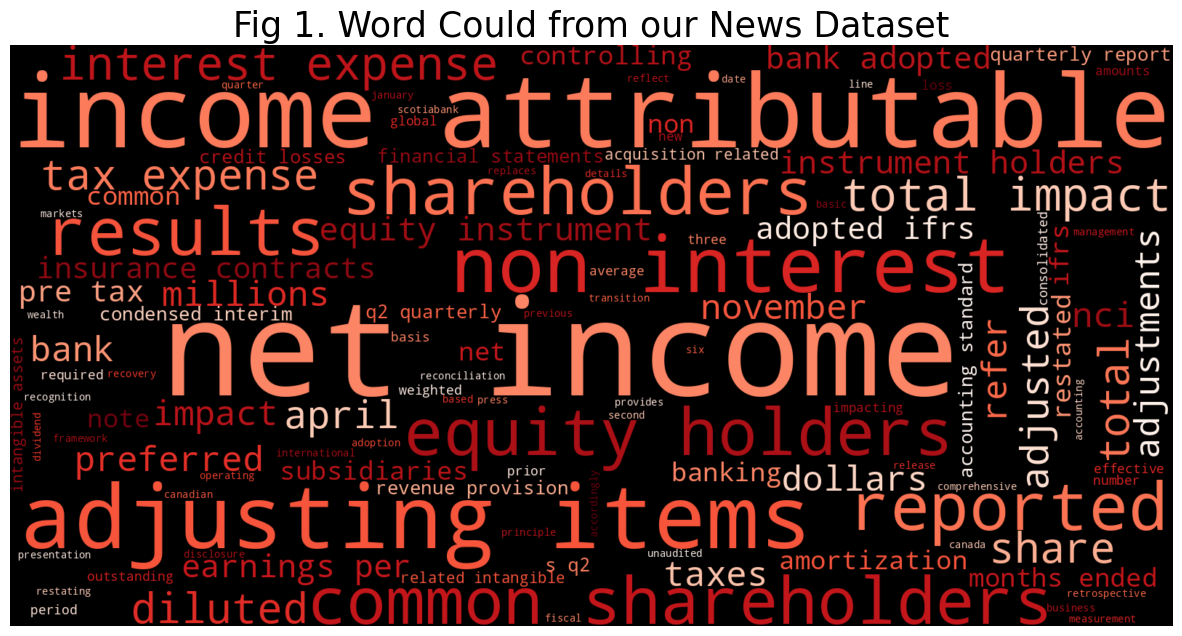

In [44]:
#Word cloud to grasp a wider idea about what the dataset is about


#define figure size
plt.figure(figsize=(15, 15))
#define a word cloud with max 2000 words and without stopwords (from same wordcloud)
wc = WordCloud(max_words=2000, width=1600, height=800, colormap='Reds', stopwords=STOPWORDS).generate(' '.join(financial_highlights_df['extracted_text']))
#show image
plt.imshow(wc, interpolation='bilinear')
#add title
plt.title("Fig 1. Word Could from our News Dataset", fontsize=25)
#hide axis
plt.axis('off')

plt.show()

> The word cloud displays the most frequently occurring and relevant terms found in the financial PDF. As expected for a financial document, it highlights key terms such as "income," "shareholder," "adjusted," "diluted," and others.

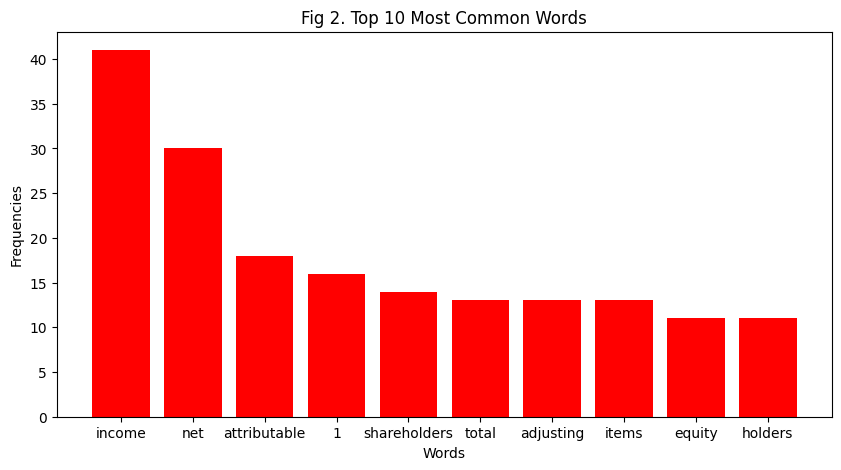

In [45]:
#get the top 10 most common words
#just for this the stop words will be eliminated
stop_words = set(stopwords.words('english'))

# Tokenize all text data and remove stop words
all_words = []
for text in financial_highlights_df['extracted_text']:
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    all_words.extend(filtered_tokens)


# Get the frequency distribution of the words
freq_dist = FreqDist(all_words)

# Get the top 10 most common words
top_10_words = freq_dist.most_common(10)

# Unzip the words and their frequencies for plotting
words, frequencies = zip(*top_10_words)

# Plot the top 10 words
plt.figure(figsize=(10, 5))
plt.bar(words, frequencies, color='red')
plt.xlabel('Words')
plt.ylabel('Frequencies')
plt.title('Fig 2. Top 10 Most Common Words')
plt.show()

>This bar graph illustrates the most frequently repeated words in the document. Complementing the word cloud, it clearly identifies the most commonly used terms, providing a detailed view of their frequency.

In [46]:
# tokenize text and remove stop words
def tokenize_and_clean(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return filtered_tokens

# Collect all words from the text column
all_words = []
for text in financial_highlights_df['extracted_text']:
    filtered_tokens = tokenize_and_clean(text)
    all_words.extend(filtered_tokens)

# get top n-grams
def get_top_ngrams(words, n, top_n=10):
    n_grams = ngrams(words, n)
    n_grams_freq = Counter(n_grams)
    return n_grams_freq.most_common(top_n)

Top Bigrams:
net income: 27
income attributable: 18
adjusting items: 13
impact adjusting: 10
attributable equity: 7
equity holders: 7
common shareholders: 7
total impact: 7
income tax: 6
tax expense: 6


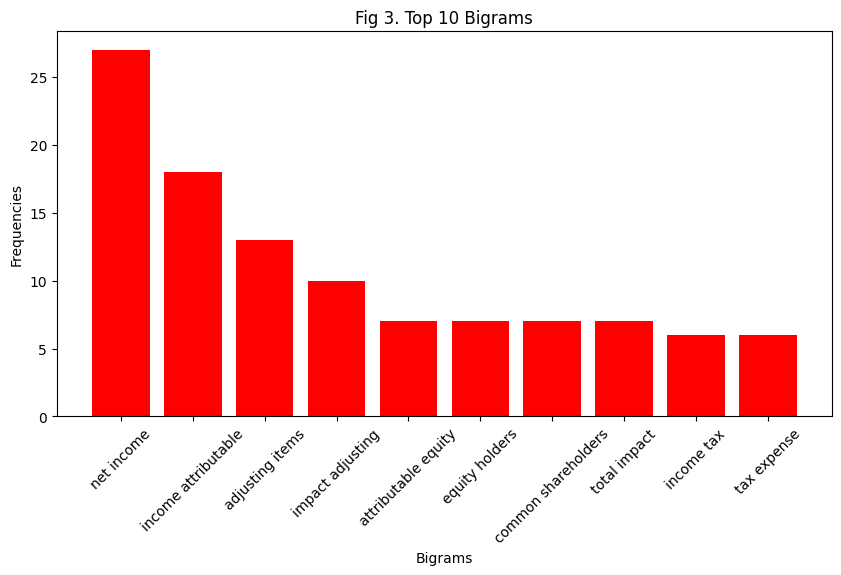

In [47]:

# Get top bigrams
top_bigrams = get_top_ngrams(all_words, 2)

# Display top bigrams
print("Top Bigrams:")
for gram, freq in top_bigrams:
    print(f"{' '.join(gram)}: {freq}")


# Plot the top bigrams
bigrams, bigram_freqs = zip(*top_bigrams)
bigram_labels = [' '.join(gram) for gram in bigrams]

plt.figure(figsize=(10, 5))
plt.bar(bigram_labels, bigram_freqs, color='red')
plt.xlabel('Bigrams')
plt.ylabel('Frequencies')
plt.title('Fig 3. Top 10 Bigrams')
plt.xticks(rotation=45)
plt.show()

>When working with bigrams and trigrams, it's crucial to highlight the most significant or related word pairs and triplets within the document. This analysis helps us understand common word combinations, which can be valuable for future training. For a conversational tool, identifying these n-grams allows us to anticipate frequently used phrases and tailor our testing and validations to better reflect the expected language use.


Top Trigrams:
net income attributable: 18
impact adjusting items: 10
income attributable equity: 7
attributable equity holders: 7
total impact adjusting: 7
income tax expense: 6
adjusting items net: 6
items net income: 6
preferred shareholders equity: 4
shareholders equity instrument: 4


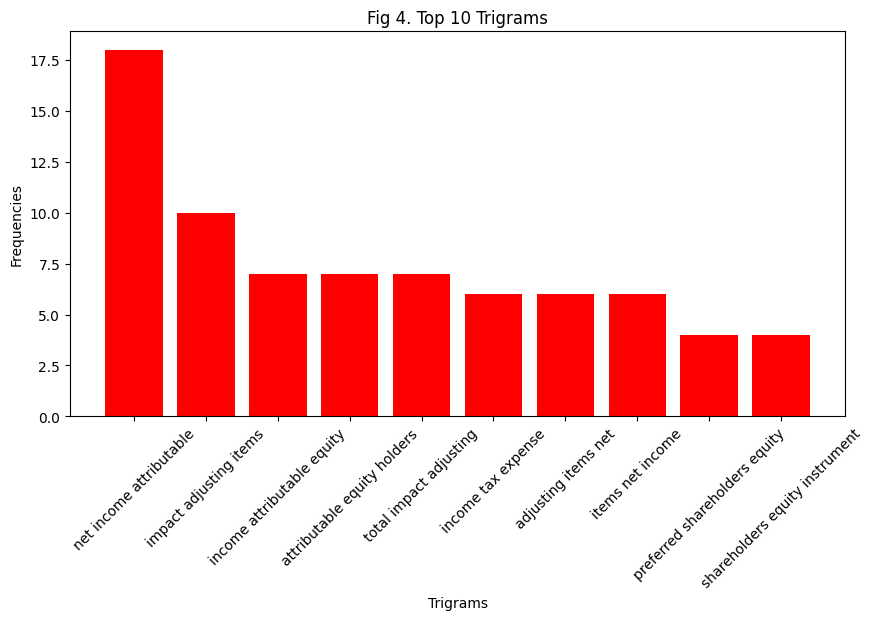

In [48]:
#get top  trigrams
top_trigrams = get_top_ngrams(all_words, 3)


# Display top trigrams
print("\nTop Trigrams:")
for gram, freq in top_trigrams:
    print(f"{' '.join(gram)}: {freq}")



# Plot the top trigrams
trigrams, trigram_freqs = zip(*top_trigrams)
trigram_labels = [' '.join(gram) for gram in trigrams]

plt.figure(figsize=(10, 5))
plt.bar(trigram_labels, trigram_freqs, color='red')
plt.xlabel('Trigrams')
plt.ylabel('Frequencies')
plt.title('Fig 4. Top 10 Trigrams')
plt.xticks(rotation=45)
plt.show()

>As observed from the bigrams and trigrams, the most common word pairs and triplets are:

* "Net income attributable": 18 occurrences
* "Net income": 27 occurrences
* "Adjusting items": 13 occurrences

>These frequent n-grams highlight key terms and phrases within the document, providing insights into the prevalent topics and terminology used.

### 7. Modeling

I. Load library and dataset

Note. since the notebook is large,all dataset has been save for future use, in case someone wish to start or continue from modeling

In [108]:
#since we are not going to do the scrapping everytime we need to run the book
#we will load the dataset

import pandas as pd
import numpy as np

#text manipulation
import nltk
from nltk.tokenize import sent_tokenize
from fuzzywuzzy import fuzz
from prettytable import PrettyTable

#transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import pipeline
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import BertTokenizer, BertForQuestionAnswering,BertModel, Trainer, TrainingArguments
from sentence_transformers import SentenceTransformer, util


#language
from langdetect import detect
from transformers import MarianMTModel, MarianTokenizer


from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer


In [50]:
#if you aleady has all the values loaded, from the begining of the notebook, then
#there is no need to run this line
#load all data already preproseced

financial_df = pd.read_csv('finnacial_release_df.csv')
table0 = pd.read_csv('table_0.csv')
table1 = pd.read_csv('table_1.csv')
table2 = pd.read_csv('table_2.csv')
table3 = pd.read_csv('table_3.csv')
table4 = pd.read_csv('table_4.csv')
table5 = pd.read_csv('table_5.csv')
table6 = pd.read_csv('table_6.csv')
table7 = pd.read_csv('table_7.csv')
table8 = pd.read_csv('table_8.csv')
table9 = pd.read_csv('table_9.csv')

In [51]:
#join tables
tablesList = [table0, table1, table2, table3, table4, table5, table6, table7, table8, table9]


In [52]:
print(torch.cuda.is_available())

True


In [104]:
#ensuring that our model will run with cuda, since we will use images, we need GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


##### II. Define metrics functions

* Bleu: is a proudct of the Brevity penalty that penalize short text that do not contain relavant info from the reference provided.
* Perplexity :  perplexity assesses the "confidence"  of a language model in predicting the next word in a sequence of words.
* Meteor : evaluates accurracy and fluency, takes the order of which words appear
* Rouge: calculate the number of ngrams matching

In [109]:
# Initialize ROUGE scorer
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

#calculate bleu
def calculate_bleu(reference, candidate):
    reference = [reference.split()]
    candidate = candidate.split()
    return sentence_bleu(reference, candidate)

#calculate meteor
def calculate_meteor(reference, candidate):
    return meteor_score([reference], candidate)

#calculate rouge
def calculate_rouge(reference, candidate):
    scores = rouge_scorer.score(reference, candidate)
    return scores



def calculate_perplexity(text, model, tokenizer):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    model.to(device)

    # Get the model's output logits
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
        logits = outputs.logits
        loss = outputs.loss.item()  # Compute the loss (negative log likelihood)

    # Calculate perplexity
    perplexity = math.exp(loss)

    return perplexity

In [55]:
#given the required data, evaluate all metrics required to determine which model is better
def evaluate_all_metrics(model, tokenizer, questions, contexts, generated_answer, reference_answer):
    bleu_scores = []
    meteor_scores = []
    rouge_scores = []
    perplexity = []

     # Calculate BLEU
    bleu_score = calculate_bleu(reference_answer, generated_answer)
    bleu_scores.append(bleu_score)

    # Calculate METEOR Unigrams can be matched based on their surface forms, stemmed forms, and meanings
    meteor_score_value = calculate_meteor(nltk.word_tokenize(reference_answer) , nltk.word_tokenize(generated_answer))
    meteor_scores.append(meteor_score_value)

    # Calculate ROUGE
    rouge_score = calculate_rouge(reference_answer, generated_answer)
    rouge_scores.append(rouge_score)

    # Calculate perplexity
    #perplexity = calculate_perplexity(questions, model, tokenizer)
    perplexity=''

    return bleu_scores, meteor_scores, rouge_scores, perplexity





> Fuzzy string matching uses Levenshtein Distance to calculate the differences between sequences.



In [99]:
def get_relevant_data(question, table_df):
    try:
        # Normalize the query
        question = question.lower().strip()

        # Use fuzzy matching for more flexible querying
        def match_row(row):
            row_str = row.astype(str).str.lower().str.strip()
            for cell in row_str:
                if fuzz.partial_ratio(question, cell) > 80:  # Threshold can be adjusted
                    return True
            return False

        matched_rows = table_df.apply(match_row, axis=1)
        results = table_df[matched_rows]

        if not results.empty:
            if len(results) > 10:
                results = results.head(10)
            return results
        else:
            return pd.DataFrame()  # Return an empty DataFrame if no results are found
    except Exception as e:
        print(f"Error retrieving data: {e}")
        return pd.DataFrame()  # Retur

In [57]:
def dataframe_to_prettytable(df):
    """Convert DataFrame to PrettyTable."""
    if df.empty:
        return None

    table = PrettyTable()
    table.field_names = df.columns.tolist()

    for index, row in df.iterrows():
        table.add_row(row.tolist())

    return table

In [58]:
def check_allTables_relevan_data(question, tablesList):

    relevant_data=''
   # Fetch relevant data from each DataFrame
    for i, table in enumerate(tablesList, start=1):
        data = get_relevant_data(question, table)
        table_str = dataframe_to_prettytable(data)
        if table_str:
            relevant_data += f"Relevant data from Table {i}:\n{table_str}\n\n"
    return relevant_data


#### III. Bert (bert-base-uncased)

Bert for question and answering: Is a model that given a question and context, identify the proper response.

>Since, the PDF has been extracted and there is no question file or guide of the questions that might pop up, embedings will be used.

> When a user types a question, base on the embedings already created, and using the cosine similarity, the most proper sentences will be collected, this list of response will then be given to the Bert model for identify the proper answer.



In [59]:
#initialize embedings
embedder = SentenceTransformer('all-MiniLM-L6-v2')

#sentence-transformers model maps sentences & paragraphs to a 384 dimensional
#dense vector space and can be used for tasks like clustering or semantic search.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [60]:
#convert document to sentences
def split_text_to_sentences(text):
    return sent_tokenize(text)

# Apply the sentence tokenizer to each row in the DataFrame
financial_df['sentences'] = financial_df['extracted_text'].apply(split_text_to_sentences)

# Create one list of all sentences
#all_sentences = [sentence for sublist in financial_df['sentences'] for sentence in sublist]

#chuncks of text, extracted from pdf
chunks_text = [sublist for sublist in financial_df['extracted_text'] ]


In [61]:
chunks_text[0] #check one chunk

'second quarter 2024 earnings release scotiabank reports second quarter results all amounts are in canadian dollars and are based on our unaudited interim condensed consolidated financial statements for the quarter ended april 30, 2024 and related notes prepared in accordance with international financial reporting standards (ifrs) as issued by the international accounting standards board (iasb), unless otherwise noted. our complete second quarter 2024 report to shareholders, including our unaudited interim financial statements for the period ended april 30, 2024, can also be found on the sedar+ website at and on the edgar section of the sec’s website at . supplementary financial information is also available, together with the second quarter 2024 report to shareholders on the investor relations page at .'

In [62]:
# Create embeddings for documents
document_embeddings = embedder.encode(chunks_text, convert_to_tensor=True)


In [63]:
len(document_embeddings) #check embedings lenght

30

In [64]:
document_embeddings_cpu = embedder.encode(chunks_text, convert_to_tensor=False)

# Save embeddings for flask app,  if is the final model selectd
np.save('document_embeddings.npy', document_embeddings_cpu)

In [65]:
# cosine similarity of the embedings and return the best options
def retrieve_context(question, document_embeddings, documents, top_k=1):
    question_embedding = embedder.encode(question, convert_to_tensor=True).to(device)

    document_embeddings = torch.tensor(document_embeddings).to(device)

    # using pytorch calculate cosine similarity
    scores = util.pytorch_cos_sim(question_embedding, document_embeddings)[0]

    # Move scores back to CPU and convert to numpy array
    scores = scores.cpu().numpy()

    # Retrieve the top_k results
    top_results = np.argpartition(-scores, range(top_k))[0:top_k]

    return [documents[idx] for idx in top_results]


In [66]:
# Initialize the tokenizer and model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForQuestionAnswering.from_pretrained(model_name)

model_Questions = pipeline("question-answering", model=model, tokenizer=tokenizer, device=device)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


> Calculate metrics for BertForQuestionAnswering using bert-base-uncased

In [67]:
def try_bert_for_questions(question, expectedResponse):

    # Retrieve relevant context base on the consine similarity
    context = retrieve_context(question, document_embeddings, chunks_text)


    # Answer the question using BertForQuestionAnswering
    result = model_Questions(question=question, context=" ".join(context))

    #check data on tables
    relevant_Tables= check_allTables_relevan_data(question, tablesList)

    #Calculate metrics for BertForQuestionAnswering using bert-base-uncased

    # Evaluate
    bleu_scores, meteor_scores, rouge_scores, perplexity = evaluate_all_metrics(model, tokenizer, question, context, result['answer'], expectedResponse)

    print("\nQuestion:", question)
    print("\nAnswer:", result['answer'])
    print("\nRelevant Tables\n",relevant_Tables)
    print("\nAnswer Expected:", expectedResponse)
    print("\nContext:", context)
    print("\nBLEU Scores:", bleu_scores)
    print("\nMETEOR Scores:", meteor_scores)
    print("\nROUGE Scores:", rouge_scores)
    print("\nPerplexity Scores:", perplexity, '\n')


In [68]:
#test 1 with  pipeline "question-answering"
question='How was the second quater earning per share?'
expected_response='Earnings per share (diluted) of $1.57, compared to $1.68'
try_bert_for_questions(question, expected_response)

<ipython-input-65-c895b7c9f62d>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  document_embeddings = torch.tensor(document_embeddings).to(device)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower ord


Question: How was the second quater earning per share?

Answer: 2023) • net income of $2,105

Relevant Tables
 

Answer Expected: Earnings per share (diluted) of $1.57, compared to $1.68

Context: ['second quarter 2024 highlights on an adjusted basis (1) (versus q2 2023) • net income of $2,105 million, compared to $2,161 million • earnings per share (diluted) of $1.58, compared to $1.69 • return on equity of 11.3%, compared to 12.3%']

BLEU Scores: [7.060301868108111e-232]

METEOR Scores: [0.11194029850746268]

ROUGE Scores: [{'rouge1': Score(precision=0.16666666666666666, recall=0.09090909090909091, fmeasure=0.11764705882352942), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16666666666666666, recall=0.09090909090909091, fmeasure=0.11764705882352942)}]

Perplexity Scores:  



In [71]:
#test 2 with  pipeline "question-answering"
question='Amortization of acquisition-related intangible assets'
expected_response='These costs relate to the amortization of intangible assets recognized upon the acquisition of businesses, excluding software, and are recorded in the Canadian Banking, International Banking and Global Wealth Management operating segments.'
try_bert_for_questions(question, expected_response)

<ipython-input-65-c895b7c9f62d>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  document_embeddings = torch.tensor(document_embeddings).to(device)



Question: Amortization of acquisition-related intangible assets

Answer: follows: a) amortization of acquisition -related intangible

Relevant Tables
 Relevant data from Table 2:
+-------------------------------------------------------------------------------------------------------------------+---------------+-----------------+---------------+-----------------+-----------------+
|                                                    ($ millions)                                                   | April 30 2024 | January 31 2024 | April 30 2023 | April 30 2024.1 | April 30 2023.1 |
+-------------------------------------------------------------------------------------------------------------------+---------------+-----------------+---------------+-----------------+-----------------+
| $Adjusting items impacting non-interest expenses (Pre-tax) $Amortization of acquisition-related intangible assets |      $18      |       $18       |      $21      |       $36       |       $42       |
|   

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


> Now the same BertForQuestionAnswering model will be tested but without using
the pipeline "question-answering", since we will not use this pipeline, we expect to see different results and longer answers.

>Since BertForQuestionAnswering is more suited for custom task and a better control of the input provided

In [72]:
# Load pre-trained model and tokenizer
model_name='bert-base-uncased'
tokenizer_bert = BertTokenizer.from_pretrained(model_name)
model_bert = BertForQuestionAnswering.from_pretrained(model_name)


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [77]:

def answer_BertForQuestionAnswering(question, expectedResponse):
    # Retrieve relevant context base on the consine similarity
    context = retrieve_context(question, document_embeddings, chunks_text)

    # Encode the input question and context
    inputs = tokenizer_bert.encode_plus(question, context, return_tensors='pt', truncation=True, max_length=512)

    # Get the input IDs and attention mask
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Forward pass through the model
    outputs = model_bert(input_ids=input_ids, attention_mask=attention_mask)

    # Get the start and end logits
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits

    # Get the most likely start and end token indices
    start_index = torch.argmax(start_logits)
    end_index = torch.argmax(end_logits)

    # Convert token indices to tokens and decode to string
    answer_tokens = tokenizer_bert.convert_ids_to_tokens(input_ids[0][start_index:end_index + 1])
    answer = tokenizer_bert.convert_tokens_to_string(answer_tokens)


    #check data on tables
    relevant_Tables= check_allTables_relevan_data(question, tablesList)

    # Evaluate
    bleu_scores, meteor_scores, rouge_scores, perplexity = evaluate_all_metrics(model_bert, tokenizer_bert, question, context, answer, expectedResponse)

    print("\nQuestion:", question)
    print("\nAnswer:", answer)
    print("\nRelevant Tables\n",relevant_Tables)
    print("\nAnswer Expected:", expectedResponse)
    print("\nContext:", context)
    print("\nBLEU Scores:", bleu_scores)
    print("\nMETEOR Scores:", meteor_scores)
    print("\nROUGE Scores:", rouge_scores)
    print("\nPerplexity Scores:", perplexity, '\n')


In [88]:
#test 1 with answer_BertForQuestionAnswering
question='How was second quarter on adjusted basis'
expected_response='the net income on second quater'
answer_BertForQuestionAnswering(question, expected_response)

<ipython-input-65-c895b7c9f62d>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  document_embeddings = torch.tensor(document_embeddings).to(device)



Question: How was second quarter on adjusted basis

Answer: [CLS] how was second quarter on adjusted basis [SEP]

Relevant Tables
 

Answer Expected: the net income on second quater

Context: ['second quarter 2024 highlights on an adjusted basis (1) (versus q2 2023) • net income of $2,105 million, compared to $2,161 million • earnings per share (diluted) of $1.58, compared to $1.69 • return on equity of 11.3%, compared to 12.3%']

BLEU Scores: [1.2508498911928379e-231]

METEOR Scores: [0.14925373134328357]

ROUGE Scores: [{'rouge1': Score(precision=0.2222222222222222, recall=0.3333333333333333, fmeasure=0.26666666666666666), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1111111111111111, recall=0.16666666666666666, fmeasure=0.13333333333333333)}]

Perplexity Scores:  



/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [75]:
#test 2 with answer_BertForQuestionAnswering

question='Amortization of acquisition-related intangible assets'
expected_response='These costs relate to the amortization of intangible assets recognized upon the acquisition of businesses, excluding software, and are recorded in the Canadian Banking, International Banking and Global Wealth Management operating segments'
answer_BertForQuestionAnswering(question, expected_response)

<ipython-input-65-c895b7c9f62d>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  document_embeddings = torch.tensor(document_embeddings).to(device)



Question: Amortization of acquisition-related intangible assets

Answer: int

Relevant Tables
 Relevant data from Table 2:
+-------------------------------------------------------------------------------------------------------------------+---------------+-----------------+---------------+-----------------+-----------------+
|                                                    ($ millions)                                                   | April 30 2024 | January 31 2024 | April 30 2023 | April 30 2024.1 | April 30 2023.1 |
+-------------------------------------------------------------------------------------------------------------------+---------------+-----------------+---------------+-----------------+-----------------+
| $Adjusting items impacting non-interest expenses (Pre-tax) $Amortization of acquisition-related intangible assets |      $18      |       $18       |      $21      |       $36       |       $42       |
|                               $Amortization of acquisition

#### IV. GPT

> First we will try gpt without sending our context of the questions, and notice how it will produce some answer base on its previous knowledge

In [89]:
#logging.basicConfig(level=logging.INFO)

# Load pre-trained model and tokenizer
model_name = "gpt2"
tokenizer_gpt = GPT2Tokenizer.from_pretrained(model_name)
model_gpt = GPT2LMHeadModel.from_pretrained(model_name)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gpt.to(device)

# Add padding token to the tokenizer if it does not exist
if tokenizer_gpt.pad_token is None:
    tokenizer_gpt.add_special_tokens({'pad_token': '[PAD]'})
    model_gpt.resize_token_embeddings(len(tokenizer_gpt))

def generate_response_GPT(prompt, model, tokenizer, device):


    #logging.info(f"Generating response for prompt: {prompt}")
    try:
        inputs = tokenizer_gpt.encode(prompt, return_tensors='pt', truncation=True, padding=True).to(device)
        attention_mask = (inputs != tokenizer_gpt.pad_token_id).long()  # Create attention mask
        outputs = model_gpt.generate(inputs, max_length=150, num_return_sequences=1, attention_mask=attention_mask)
        response = tokenizer_gpt.decode(outputs[0], skip_special_tokens=True)
        return response
    except Exception as e:
       # logging.error(f"Error generating response: {e}")
        return "Sorry, I couldn't generate a response."



tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [90]:
device

device(type='cuda')

In [110]:


def chatbot(query, tables, text_df, expectedResponse):
    # Normalize the query
    query = query.lower().strip()

    # Generate a response using the GPT model
    response = generate_response_GPT(query, model, tokenizer, device)

    # Initialize relevant data string
    relevant_data = ""

    # Fetch relevant data from text_df first
    text_data = get_relevant_data(query, text_df)
    text_table = dataframe_to_prettytable(text_data)
    if text_table:
        relevant_data += f"Relevant data from Text DataFrame:\n{text_table}\n\n"

    # Fetch relevant data from each DataFrame
    for i, table in enumerate(tables, start=1):
        data = get_relevant_data(query, table)
        table_str = dataframe_to_prettytable(data)
        if table_str:
            relevant_data += f"Relevant data from Table {i}:\n{table_str}\n\n"

    # Combine GPT's response with relevant data
    final_response = f"{response}\n\n{relevant_data}"

     # Evaluate
    bleu_scores, meteor_scores, rouge_scores, perplexity = evaluate_all_metrics(model_gpt, tokenizer_gpt, query, '', final_response, expectedResponse)

    print("\nBLEU Scores:", bleu_scores)
    print("\nMETEOR Scores:", meteor_scores)
    print("\nROUGE Scores:", rouge_scores)
    print("\nPerplexity Scores:", calculate_perplexity(query,model_gpt,tokenizer_gpt), '\n')



    return final_response


# Run the chatbot
while True:
    query = input("You: ")
    if query.lower() == 'exit':
        break
    response = chatbot(query, tablesList, [financial_df],'')
    print(f"Bot: {response}")

You: net income


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error retrieving data: 'list' object has no attribute 'apply'

BLEU Scores: [0]

METEOR Scores: [0.0]

ROUGE Scores: [{'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0, recall=0, fmeasure=0)}]

Perplexity Scores: 993543579668526.1 

Bot: net income

Relevant data from Table 1:
+-----------------------------------------------------------------------+---------------+-----------------+---------------+-----------------+-----------------+
|                        (Unaudited) ($ millions)                       | April 30 2024 | January 31 2024 | April 30 2023 | April 30 2024.1 | April 30 2023.1 |
+-----------------------------------------------------------------------+---------------+-----------------+---------------+-----------------+-----------------+
|                          Net interest income                          |     $4,694    |      $4,773     |     $4,460    |      $9,467     |      

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error retrieving data: 'list' object has no attribute 'apply'

BLEU Scores: [0]

METEOR Scores: [0.0]

ROUGE Scores: [{'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0, recall=0, fmeasure=0)}]

Perplexity Scores: 1.0471550095107651e+36 

Bot: how much was the net income attributable to equity holders?

Relevant data from Table 1:
+-------------------------------------------------------+---------------+-----------------+---------------+-----------------+-----------------+
|                (Unaudited) ($ millions)               | April 30 2024 | January 31 2024 | April 30 2023 | April 30 2024.1 | April 30 2023.1 |
+-------------------------------------------------------+---------------+-----------------+---------------+-----------------+-----------------+
|                       Net income                      |     $2,092    |      $2,199     |     $2,146    |      $4,291     |      $3,904    

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error retrieving data: 'list' object has no attribute 'apply'

BLEU Scores: [0]

METEOR Scores: [0.0]

ROUGE Scores: [{'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0, recall=0, fmeasure=0)}]

Perplexity Scores: 4.038392906185619e+29 

Bot: shareholders equity


You: exit


> Notice as this model is not able to answer simple questions, this is because even though it have a previews knowledge of data gather from internet, it does not know the context where it is

> Now, let's train gpt base on context taken from calculating the similiarty between question and text

In [111]:
# Load pre-trained model and tokenizer
model_name = "gpt2"
tokenizer_gpt = GPT2Tokenizer.from_pretrained(model_name)
model_gpt = GPT2LMHeadModel.from_pretrained(model_name)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gpt.to(device)

# Add padding token to the tokenizer if it does not exist
if tokenizer_gpt.pad_token is None:
    tokenizer_gpt.add_special_tokens({'pad_token': '[PAD]'})
    model_gpt.resize_token_embeddings(len(tokenizer_gpt))

def generate_response_GPTC(prompt, context, model, tokenizer, device):

    prompt = f"Context: {context}\nQuestion: {question}"
    #logging.info(f"Generating response for prompt: {prompt}")
    try:
        inputs = tokenizer_gpt.encode(prompt, return_tensors='pt', truncation=True, padding=True).to(device)
        attention_mask = (inputs != tokenizer_gpt.pad_token_id).long()  # Create attention mask
        outputs = model_gpt.generate(inputs, max_length=150, num_return_sequences=1, attention_mask=attention_mask)
        response = tokenizer_gpt.decode(outputs[0], skip_special_tokens=True)
        return response
    except Exception as e:
       # logging.error(f"Error generating response: {e}")
        return "Sorry, I couldn't generate a response."

In [112]:

def chatbot(query, tables, text_df, expectedResponse):
    # Normalize the query
    query = query.lower().strip()

    # Retrieve relevant context base on the consine similarity
    context = retrieve_context(query, document_embeddings, chunks_text)

    # Generate a response using the GPT model
    response = generate_response_GPTC(query, context, model, tokenizer, device)

    # Initialize relevant data string
    relevant_data = ""

    # Fetch relevant data from text_df first
    text_data = get_relevant_data(query, text_df)
    text_table = dataframe_to_prettytable(text_data)
    if text_table:
        relevant_data += f"Relevant data from Text DataFrame:\n{text_table}\n\n"

    # Fetch relevant data from each DataFrame
    for i, table in enumerate(tables, start=1):
        data = get_relevant_data(query, table)
        table_str = dataframe_to_prettytable(data)
        if table_str:
            relevant_data += f"Relevant data from Table {i}:\n{table_str}\n\n"

    # Combine GPT's response with relevant data
    final_response = f"{response}\n\n{relevant_data}"

     # Evaluate
    bleu_scores, meteor_scores, rouge_scores, perplexity = evaluate_all_metrics(model_gpt, tokenizer_gpt, query, context, final_response, expectedResponse)

    print("\nBLEU Scores:", bleu_scores)
    print("\nMETEOR Scores:", meteor_scores)
    print("\nROUGE Scores:", rouge_scores)
    print("\nPerplexity Scores:", calculate_perplexity(query,model_gpt,tokenizer_gpt), '\n')




    return final_response


# Run the chatbot
while True:
    query = input("You: ")
    if query.lower() == 'exit':
        break
    response = chatbot(query, tablesList, [financial_df],'')
    print(f"Bot: {response}")

You: How much was the net income attributable to equity holders?


<ipython-input-65-c895b7c9f62d>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  document_embeddings = torch.tensor(document_embeddings).to(device)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error retrieving data: 'list' object has no attribute 'apply'

BLEU Scores: [0]

METEOR Scores: [0.0]

ROUGE Scores: [{'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0, recall=0, fmeasure=0)}]

Perplexity Scores: 2.2745979019775788e+36 

Bot: Sorry, I couldn't generate a response.

Relevant data from Table 1:
+-------------------------------------------------------+---------------+-----------------+---------------+-----------------+-----------------+
|                (Unaudited) ($ millions)               | April 30 2024 | January 31 2024 | April 30 2023 | April 30 2024.1 | April 30 2023.1 |
+-------------------------------------------------------+---------------+-----------------+---------------+-----------------+-----------------+
|                       Net income                      |     $2,092    |      $2,199     |     $2,146    |      $4,291     |      $3,904     |
| Net income attri

<ipython-input-65-c895b7c9f62d>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  document_embeddings = torch.tensor(document_embeddings).to(device)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error retrieving data: 'list' object has no attribute 'apply'

BLEU Scores: [0]

METEOR Scores: [0.0]

ROUGE Scores: [{'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0, recall=0, fmeasure=0)}]

Perplexity Scores: 5.307933999583882e+26 

Bot: Sorry, I couldn't generate a response.

Relevant data from Table 1:
+-----------------------------------------------------------------------+---------------+-----------------+---------------+-----------------+-----------------+
|                        (Unaudited) ($ millions)                       | April 30 2024 | January 31 2024 | April 30 2023 | April 30 2024.1 | April 30 2023.1 |
+-----------------------------------------------------------------------+---------------+-----------------+---------------+-----------------+-----------------+
|                               Net income                              |     $2,092    |      $2,199     |     $2,

>since this model is not train on question and aswer it does not know how to reply questions, even when the context is giving to the model

#### V. Translations





For translating to Spanish English, english spanish Helsinki-NLP/opus-mt-es-en will be used, from hugging face

In [127]:
# Load models and tokenizers for both translation en to es and es to en directions
#https://huggingface.co/Helsinki-NLP/opus-mt-es-en
model_name_es_to_en = 'Helsinki-NLP/opus-mt-es-en'
model_name_en_to_es = 'Helsinki-NLP/opus-mt-en-es'

tokenizer_es_to_en = MarianTokenizer.from_pretrained(model_name_es_to_en)
model_es_to_en = MarianMTModel.from_pretrained(model_name_es_to_en)

tokenizer_en_to_es = MarianTokenizer.from_pretrained(model_name_en_to_es)
model_en_to_es = MarianMTModel.from_pretrained(model_name_en_to_es)

In [142]:

#take text no matter the language, detect language and only if is spanish make the translation
def translate_text(text, model, tokenizer):


    #make translation to spanish

    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    # Perform the translation
    with torch.no_grad():
        translated = model.generate(**inputs)

    # Decode the translated text
    translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)
    return translated_text


def obtainTranslation(text, target='en'):
    if  text == '':
        return '', target
    # Detect language of the input text
    language = detect(text)
    isInput = target == 'es'

    # Determine if translation is needed
    shouldTranslate = (language != target)

    # If the language matches the target or translation is not needed
    if not shouldTranslate and language == target:
        return text, language

    # If translation is needed and input language is Spanish
    if shouldTranslate and language == 'es':
        result = translate_text(text, model_es_to_en, tokenizer_es_to_en)
    elif shouldTranslate and language == 'en':
        result = translate_text(text, model_en_to_es, tokenizer_en_to_es)
    else:
        result = 'We only support English and Spanish.'

    return result, language



In [138]:

#input
result, language = obtainTranslation('Cual fue la provision para perdidas de credito en los prestamos en funcionamiento')
print(result, f'Lang={language}')

#output
result, language = obtainTranslation('What is the quarterly amount of 2024 ', 'es')
print(result,  f'Lang={language}')

#input
result, language = obtainTranslation('Hello, how are you?')
print(result, f'Lang={language}')

#output
result, language = obtainTranslation('what is the financial statement?')
print(result, f'Lang={language}')


What was the provision for credit losses on loans in operation? Lang=es
¿Cuál es el importe trimestral de 2024 Lang=en
Hello, how are you? Lang=en
what is the financial statement? Lang=en


>Integrate  translation with the model

In [143]:

def answer_BertForQuestionAnswering(question, expectedResponse):
    #translate question if necesary
    result, language = obtainTranslation(question)
    #take question from translation
    question =result
    print('Question after translation', question, language)

    # Retrieve relevant context base on the consine similarity
    context = retrieve_context(question, document_embeddings, chunks_text)

    # Encode the input question and context
    inputs = tokenizer_bert.encode_plus(question, context, return_tensors='pt', truncation=True, max_length=512)

    # Get the input IDs and attention mask
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Forward pass through the model
    outputs = model_bert(input_ids=input_ids, attention_mask=attention_mask)

    # Get the start and end logits
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits

    # Get the most likely start and end token indices
    start_index = torch.argmax(start_logits)
    end_index = torch.argmax(end_logits)

    # Convert token indices to tokens and decode to string

    answer_tokens = tokenizer_bert.convert_ids_to_tokens(input_ids[0][start_index:end_index + 1])
    answer = tokenizer_bert.convert_tokens_to_string(answer_tokens)

    print('\nEnglish Answer', answer)
    #translate output to language needed
    result, language = obtainTranslation(answer, language)
    print('\n Answer after translation ', result, language)


    #check data on tables
    relevant_Tables= check_allTables_relevan_data(question, tablesList)

    # Evaluate
    bleu_scores, meteor_scores, rouge_scores, perplexity = evaluate_all_metrics(model_bert, tokenizer_bert, question, context, answer, expectedResponse)

    print("\nResults:")
    print("\nQuestion:", question)
    print("\nAnswer:", result)
    print("\nRelevant Tables\n",relevant_Tables)
    print("\nAnswer Expected:", expectedResponse)
    print("\nContext:", context)
    print("\nBLEU Scores:", bleu_scores)
    print("\nMETEOR Scores:", meteor_scores)
    print("\nROUGE Scores:", rouge_scores)
    print("\nPerplexity Scores:", perplexity, '\n')

In [147]:
#'How was the second quater earning per share?'

#test 1 with answer_BertForQuestionAnswering
question='what is the anual net income?'
expected_response='Net income attributable to equity holders was $671 million and adjusted net income attributable to equity holders was $677'
answer_BertForQuestionAnswering(question, expected_response)

Question after translation what is the anual net income? en

English Answer the anual net income ? [SEP] [UNK] [SEP]

 Answer after translation  the anual net income ? [SEP] [UNK] [SEP] en


<ipython-input-65-c895b7c9f62d>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  document_embeddings = torch.tensor(document_embeddings).to(device)



Results:

Question: what is the anual net income?

Answer: the anual net income ? [SEP] [UNK] [SEP]

Relevant Tables
 Relevant data from Table 1:
+--------------------------+---------------+-----------------+---------------+-----------------+-----------------+
| (Unaudited) ($ millions) | April 30 2024 | January 31 2024 | April 30 2023 | April 30 2024.1 | April 30 2023.1 |
+--------------------------+---------------+-----------------+---------------+-----------------+-----------------+
|        Net income        |     $2,092    |      $2,199     |     $2,146    |      $4,291     |      $3,904     |
+--------------------------+---------------+-----------------+---------------+-----------------+-----------------+

Relevant data from Table 2:
+--------------+---------------+-----------------+---------------+-----------------+-----------------+
| ($ millions) | April 30 2024 | January 31 2024 | April 30 2023 | April 30 2024.1 | April 30 2023.1 |
+--------------+---------------+-----------

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [146]:
#test 1 with answer_BertForQuestionAnswering
question='Cual es el ingreso anual'
#How much was the net income attributable to equity holders
expected_response='The provision for credit losses on performing loans was $32 million, compared to $88 million. The provision this quarter was driven by retail portfolio growth'
answer_BertForQuestionAnswering(question, expected_response)

Question after translation What is the annual income? es

English Answer the annual income ? [SEP]


<ipython-input-65-c895b7c9f62d>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  document_embeddings = torch.tensor(document_embeddings).to(device)



 Answer after translation  los ingresos anuales? [SEP] en

Results:

Question: What is the annual income?

Answer: los ingresos anuales? [SEP]

Relevant Tables
 

Answer Expected: The provision for credit losses on performing loans was $32 million, compared to $88 million. The provision this quarter was driven by retail portfolio growth

Context: ['second quarter 2024 highlights on an adjusted basis (1) (versus q2 2023) • net income of $2,105 million, compared to $2,161 million • earnings per share (diluted) of $1.58, compared to $1.69 • return on equity of 11.3%, compared to 12.3%']

BLEU Scores: [0]

METEOR Scores: [0.01865671641791045]

ROUGE Scores: [{'rouge1': Score(precision=0.25, recall=0.04, fmeasure=0.06896551724137932), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.25, recall=0.04, fmeasure=0.06896551724137932)}]

Perplexity Scores:  



#### 9. Conclussions